In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('PPG_Dataset.csv')

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
y=LabelEncoder().fit_transform(y)

# Normalize each signal
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # IMPORTANT for medical data
)

# Reshape for deep learning
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model = Sequential([
    Conv1D(32, 7, activation='relu', input_shape=(2000,1)),
    MaxPooling1D(2),

    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu'),
    GlobalAveragePooling1D(),

    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2,callbacks=[early_stop])

Epoch 1/30


/home/devanshvishwa/Github/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7415 - loss: 0.5949 - val_accuracy: 0.9563 - val_loss: 0.3533
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9715 - loss: 0.1856 - val_accuracy: 0.9563 - val_loss: 0.1861
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9715 - loss: 0.1491 - val_accuracy: 0.9563 - val_loss: 0.1832
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9715 - loss: 0.1418 - val_accuracy: 0.9563 - val_loss: 0.1875
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9715 - loss: 0.1383 - val_accuracy: 0.9563 - val_loss: 0.1798
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9715 - loss: 0.1378 - val_accuracy: 0.9563 - val_loss: 0.1953
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9715 - loss: 0.1426 - val_accuracy: 0.9563 - val_loss: 0.1853
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9715 - loss: 0.1398 - val_accuracy: 0.9563 - val_loss: 0.

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9477 - loss: 0.2111
Test Loss: 0.21107950806617737
Test Accuracy: 0.9476743936538696


In [20]:
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.93      0.95       259
           1       0.94      0.96      0.95       257

    accuracy                           0.95       516
   macro avg       0.95      0.95      0.95       516
weighted avg       0.95      0.95      0.95       516



In [22]:
from sklearn.metrics import roc_auc_score

roc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc)


ROC-AUC: 0.942415456034133


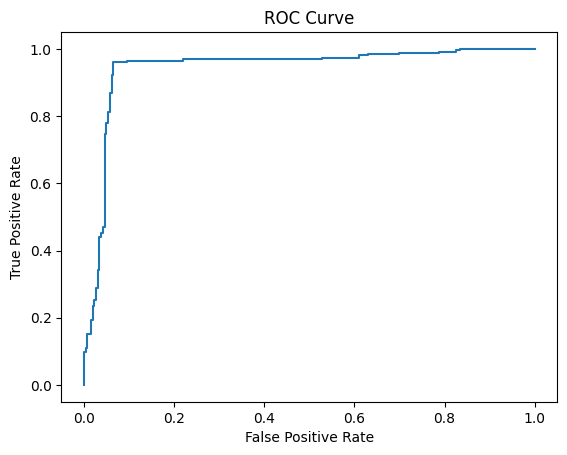

In [24]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)


[[242  17]
 [ 10 247]]
